In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['VL_ROOT_DIR'] = '/home/avc6555/research/MedH/Mitigation/LVLM_interp'

import sys
sys.path.append("/home/avc6555/research/MedH/Mitigation/LVLM_interp")

from methods.llava_utils import retrieve_logit_lens_llava, load_llava_state
# from methods.blip_utils import retrieve_logit_lens_blip, load_blip_state

from methods.utils import load_image
from methods.algorithms import internal_confidence, internal_confidence_heatmap, internal_confidence_segmentation

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

Current working directory: /home/avc6555/research/MedH/Mitigation/LVLM_interp/demos ['/data/aofei/conda/env/medh/lib/python310.zip', '/data/aofei/conda/env/medh/lib/python3.10', '/data/aofei/conda/env/medh/lib/python3.10/lib-dynload', '', '/home/avc6555/.local/lib/python3.10/site-packages', '/data/aofei/conda/env/medh/lib/python3.10/site-packages', '__editable__.llava_med-1.5.0.finder.__path_hook__', '/home/avc6555/research/MedH/visualize/toolkits/Visualizer', '/home/avc6555/research/MedH/Mitigation/LVLM_interp', '/home/avc6555/research/MedH/Mitigation/LVLM_interp/src/caption']


/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# model_name = "llava7b" # or "blip7b"
model_name = "mistral_llava_med_1.5"
# tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name, peft_path=args.peft_path)
if model_name.startswith("llava") or "llava" in model_name:
    model_state = load_llava_state()
    retrieve_logit_lens = retrieve_logit_lens_llava
# elif model_name.startswith("blip"):
#     model_state = load_blip_state()
#     retrieve_logit_lens = retrieve_logit_lens_blip

/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at /data/aofei/LLM/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.12.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.10.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.9.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.7.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.20.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.20.self_attn.q_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.23.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.14.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.16.self_attn.q_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.12.self_attn.k_proj.weight', 'model.

In [31]:
# img_path = os.path.join(os.environ["VL_ROOT_DIR"], "images/COCO_val2014_000000562150.jpg")
img_path = "/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med/visualize/images/"+ "example1.jpg"
caption, softmax_probs = retrieve_logit_lens(model_state, img_path)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [32]:
caption

'the body. In this case, the CT scan is focused on the abdomen, which is the region of the body that contains the digestive organs, such as the stomach, intestines, liver, and pancreas, as well as other structures like blood vessels and lymph nodes.'

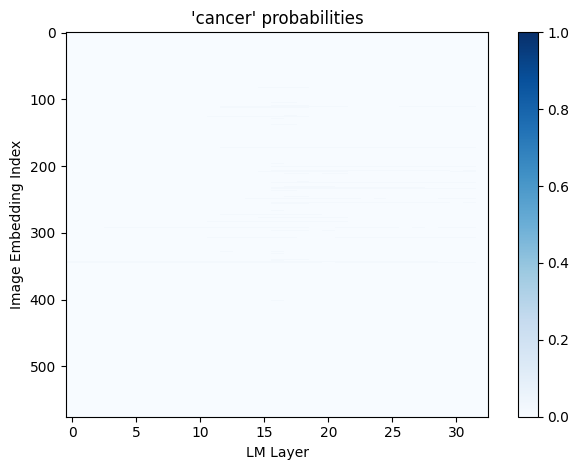

In [41]:
class_ = 'cancer'
heatmap_data = internal_confidence_heatmap(model_state['tokenizer'], softmax_probs, class_)
num_image_embeddings = softmax_probs.shape[2]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{class_}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 1)
plt.colorbar()
plt.show()

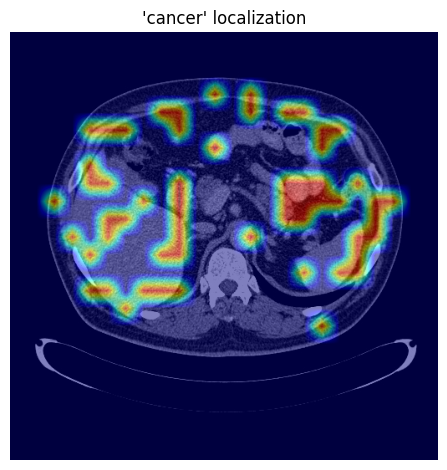

In [42]:
if model_name.startswith("llava") or "llava" in model_name:
    img = load_image(img_path)
    img_width, img_height = img.size

    segmentation = internal_confidence_segmentation(model_state['tokenizer'], softmax_probs, class_, num_patches=24)
    segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))

    plt.imshow(img)
    plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=.5)
    plt.axis('off')
    
    plt.title(f"'{class_}' localization")
    plt.tight_layout()
    plt.show()
else:
    print(f"Cannot visualize localization for {model_name}")

In [9]:
print(f"Internal confidence: {internal_confidence(model_state['tokenizer'], softmax_probs, class_)}")

Internal confidence: 0.05693778395652771


In [44]:
model_state.keys()

dict_keys(['vocabulary', 'vocab_embeddings', 'tokenizer', 'execute_model', 'register_hook', 'register_pre_hook', 'hidden_layer_embedding', 'model', 'model_name', 'image_processor'])

In [47]:
for name, module in model_state['model'].named_modules():
    print(name)
    if "attention" in name and "output" in name:  # Adjust name matching for your architecture
        print(name)
        # module.register_forward_hook(gradient_hook)


model
model.embed_tokens
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.act_fn
model.layers.0.input_layernorm
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.act_fn
model.layers.1.input_layernorm
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.